# Protein Complexes in Ovarian Cancer

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Import patient data as well as a list of protein complexes from CORUM (http://mips.helmholtz-muenchen.de/corum/#download 'Complete Complexes')

In [2]:
data = pd.read_csv('proteinGroups_cleaned.txt', sep='\t')

# Remove duplicate rows from the dataset
data = data.set_index('Gene_Name')
data = data.loc[~data.index.duplicated()]
complexData = pd.read_csv('allComplexes.txt', sep='\t')

### Create a workable dictionary of protein complex information

In [3]:
# Select for human complexes
complexData = complexData.loc[complexData['Organism'] == 'Human']

# Split the proteins in each complex into invdividual columns of a new df
subunitNames = complexData['subunits(Gene name)'].str.split(';', expand = True)
subunitNames.index = complexData.ComplexName

# Create a dictionary (key = complex name, value = list of proteins in complex) and remove None values
subunitNames = subunitNames.loc[~subunitNames.index.duplicated()]
subunitNames = subunitNames.transpose().to_dict('list')
for key, val in subunitNames.items():
    subunitNames[key] = [value for value in val if value != None]

### Define basic analysis and plotting functions

In [4]:
"""
get_ratio_df
-----------
All patients, single protein, tumor vs normal
Returns two dataframes: tumor and normal containing ratios for the proteins

Parameters:
    prot1, prot2 = (gene) names of the two proteins to be compared (ratio of prot1 / prot2)
    
Returns:
    Two dataframes: tumor and normal containing ratios for the proteins
  
"""
def get_ratio_df(prot1, prot2):
    # Make sure that both proteins are in our dataset
    if not data.index.contains(prot1) or not data.index.contains(prot2): return None, None
    
    # Create a dataframe of ratios for easy testing
    tumor_rows_list = []
    normal_rows_list = []
    for patient in data.columns:
        # Determine the patient type
        sample_type = 'Tumor'
        if '_NM' in patient: sample_type = 'Normal'
        # Find the ratio prot1 / prot2 and create a new row for the dataframe
        if data.at[prot2, patient] == 0: 
            ratio = np.nan
        else: 
            ratio = data.at[prot1, patient] / data.at[prot2, patient]
        row_dict = {'Ratio': ratio, 'Sample_Type': sample_type}
        # Add the new row to the tumor or normal dataframe, depending on the sample type
        if sample_type == 'Tumor':
            tumor_rows_list.append(row_dict)
        else:
            normal_rows_list.append(row_dict)
            
    tumor_ratio_df = pd.DataFrame(tumor_rows_list)
    normal_ratio_df = pd.DataFrame(normal_rows_list)
    
    return tumor_ratio_df, normal_ratio_df

In [5]:
"""
test_complex
------------
Perform statistical tests on every combination of proteins in a given complex, plotting those with significant p-values

Parameters:
    prot_list = list of proteins in a complex
    test_type = type of test to perform, levene or ttest
    
Returns:
    prints significant t-tests or levene tests

"""
def test_complex(prot_list, test_type = 'ttest'):
    if test_type != 'ttest' and test_type != 'levene':
        print("Error: test_type must equal 'ttest' or 'levene'")
        return
    
    alpha = 0.05 / len(prot_list)
    
    for i in range(0, len(prot_list) - 1):
        for j in range(i+1, len(prot_list)):
            tumor_ratio_df, normal_ratio_df = get_ratio_df(prot_list[i], prot_list[j])
            if tumor_ratio_df is None or normal_ratio_df is None: continue
            
            if test_type == 'ttest':
                test_result = scipy.stats.ttest_ind(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]
            else:
                test_result = scipy.stats.levene(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]
            
            if test_result < alpha:
                print(prot_list[i] + ' / ' + prot_list[j] + ': ' + str(test_result))

In [6]:
"""
plot_ratios
-----------
Create a seaborn plot for the ratios in a dataframe

Parameters:
    plot_data = dataframe with ratio values (output of test_complex)
    complex_name = name of the complex
    
Returns:
    Displays a plot of the data
    
"""
def plot_ratios(prot1, prot2):
    
    # Set up dataframe for plotting
    tumor_ratio_df, normal_ratio_df = get_ratio_df(prot1, prot2)
    plot_data = tumor_ratio_df.append(normal_ratio_df)
    
    a4_dims = (10, 10)
    fig, ax = plt.subplots(figsize=a4_dims)

    #Create the plot
    boxplt = sns.boxplot(data=plot_data, x='Sample_Type', y='Ratio', showfliers=False)
    boxplt = sns.stripplot(data=plot_data, x='Sample_Type', y='Ratio', dodge=True, jitter=True, color='.3')

    #Add styling
    boxplt.set_title('Ratio of ' + prot1 + ' and ' + prot2, fontsize='25')
    boxplt.set_xlabel('')
    boxplt.set_ylabel('Protein Expression Ratio', fontsize='20')
    boxplt.tick_params(labelsize='15')
    
    #Adjust legend
    #handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[0:2], ['Tumor', 'Normal'], title='Sample Type', fontsize='12', frameon=False)
    #boxplt.get_legend().get_title().set_fontsize('13')
    #boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))

In [7]:
test_complex(['PSMD11', 'PSMD12', 'PSMD9', 'PSMD14', 'PSMD3', 'PSMD10', 'PSMC3', 'PSMC2', 'PSMC4', 'PSMD8', 'PSMD7', 'PSMD4', 'PSMC1', 'PSMC5', 'PSMC6', 'PSMD2', 'PSMD6', 'PSMD5', 'PSMD1', 'PSMD13'])

PSMD11 / PSMC3: 0.0018076373775864523
PSMD12 / PSMC3: 4.192512092633666e-08
PSMD12 / PSMC2: 6.577562703806266e-06
PSMD12 / PSMC5: 0.0006271522358318283
PSMD12 / PSMC6: 4.0700194370717815e-13
PSMD12 / PSMD2: 1.7554832411980443e-09
PSMD14 / PSMC6: 5.921219099663624e-06
PSMD3 / PSMC6: 2.0165820007418735e-05
PSMC3 / PSMC6: 3.830136602362548e-09
PSMC2 / PSMC5: 0.00224492469707792
PSMC4 / PSMC6: 2.2617319487423166e-08
PSMC4 / PSMD2: 1.6648711403977838e-05
PSMD8 / PSMC6: 0.0002770066590026403
PSMD4 / PSMC6: 3.604234574156388e-08
PSMD4 / PSMD2: 8.349326106642772e-06
PSMC1 / PSMC6: 1.8011465517051513e-07
PSMC5 / PSMC6: 2.3326823338813802e-07
PSMC5 / PSMD2: 0.0005650638769471557


In [8]:
test_complex(['DLL1', 'CDH2', 'CTNNB1'])

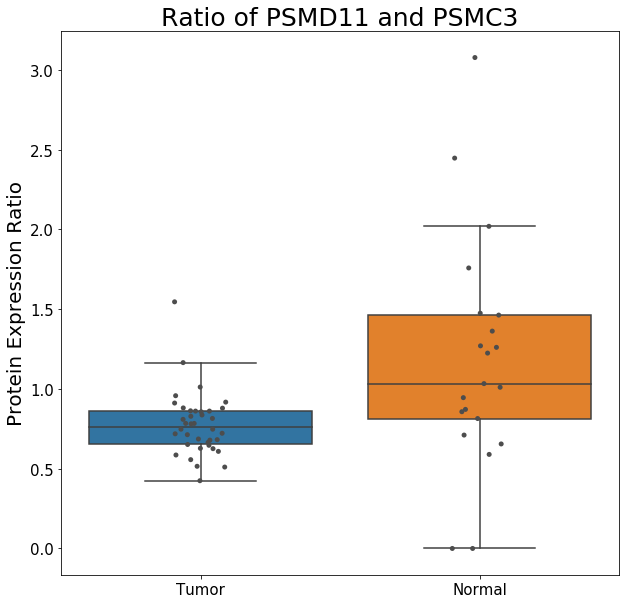

In [9]:
plot_ratios('PSMD11', 'PSMC3')

## Test for differences in mean (ratios) in all complexes

In [10]:
for key, val in subunitNames.items():
    print(key)
    test_complex(val)

BCL6-HDAC4 complex
BCL6-HDAC5 complex
BCL6-HDAC7 complex
Multisubunit ACTR coactivator complex
Condensin I complex
BLOC-3 (biogenesis of lysosome-related organelles complex 3)
BLOC-2 (biogenesis of lysosome-related organelles complex 2)
MUS81-CDS1 complex
NCOR complex
BLOC-1 (biogenesis of lysosome-related organelles complex 1)
Arp2/3 protein complex
PA28gamma complex
PA28 complex
PSME1 / PSME2: 0.004599831766158705
PA700 complex
PSMD11 / PSMC3: 0.0018076373775864523
PSMD12 / PSMC3: 4.192512092633666e-08
PSMD12 / PSMC2: 6.577562703806266e-06
PSMD12 / PSMC5: 0.0006271522358318283
PSMD12 / PSMC6: 4.0700194370717815e-13
PSMD12 / PSMD2: 1.7554832411980443e-09
PSMD14 / PSMC6: 5.921219099663624e-06
PSMD3 / PSMC6: 2.0165820007418735e-05
PSMC3 / PSMC6: 3.830136602362548e-09
PSMC2 / PSMC5: 0.00224492469707792
PSMC4 / PSMC6: 2.2617319487423166e-08
PSMC4 / PSMD2: 1.6648711403977838e-05
PSMD8 / PSMC6: 0.0002770066590026403
PSMD4 / PSMC6: 3.604234574156388e-08
PSMD4 / PSMD2: 8.349326106642772e-06
P

PSMA5 / PSMB2: 0.0022953399794339094
PSMB3 / PSMB2: 0.0022187394610889304
PSMB2 / PSMA6: 5.845815113761061e-05
HUIC complex
BRCA1-RAD50-MRE11-NBS1 complex
Ubiquitin E3 ligase (VHL, TCEB1, TCEB2, CUL2, RBX1)
DNA ligase IV-XRCC4 complex
Ubiquitin E3 ligase (ASB2, TCEB1, TCEB2, CUL5, RNF7)
Ubiquitin E3 ligase (ASB1, TCEB1, TCEB2, CUL5, RNF7)
Ubiquitin E3 ligase (ASB6, TCEB1, TCEB2, CUL5, RNF7)
Ubiquitin E3 ligase (ASB7, TCEB1, TCEB2, CUL5, RNF7)
Ubiquitin E3 ligase (ASB12, TCEB1, TCEB2, CUL5, RNF7)
DNA ligase III-XRCC1 complex
DNA ligase IV-XRCC1 complex
Ubiquitin E3 ligase (WSB1, TCEB1, TCEB2, CUL5, RBX1)
CRSP complex
CAND1-CUL1-RBX1 complex
ARF-Mule complex
CAND1-CUL2-RBX1 complex
CAND1-CUL3-RBX1 complex
CAND1-CUL4A-RBX1 complex
CAND1-CUL4B-RBX1 complex
Ubiquitin E3 ligase (SKP1A, SKP2, CUL1)
Ubiquitin E3 ligase (SKP1A, BTRC, CUL1)
SMCC complex
NAT complex
Mediator complex
ARC complex
HuCHRAC complex
WICH complex
SWI-SNF chromatin remodeling-related-BRCA1 complex
BRCA1-CTIP-ZBRK1 repres

SRSF9 / DDX39B: 1.3333341622402843e-10
SRSF6 / DDX39B: 4.897257958109177e-06
SF3B2 / DDX39B: 7.5875351489177e-08
PRPF4B / DDX39B: 1.2735116574506432e-07
SNW1 / DDX39B: 7.624468593947535e-12
THOC5 / DDX39B: 4.928218499601885e-07
DNA ligase IV-condensin complex
DNA ligase IV-XRCC4-XLF complex
Artemis-DNA-PK complex
DNA ligase III-XRCC1-PNK-DNA-pol III multiprotein complex
ERCC1-ERCC4-MSH2 complex
MSH2-MSH6-PMS2-MLH1 complex
MSH2-MSH6-PMS1-MLH1 complex
MSH2-MSH6 complex
MSH2-MSH3 complex
PCNA-MutS-alpha-MutL-alpha-DNA complex
MutL-beta complex
Ubiquitin E3 ligase (UBADC1, RNF123)
MCM complex
ORC complex (origin recognition complex)
Ubiquitin E3 ligase (SKP1A, FBXW2, CUL1)
Ubiquitin E3 ligase (DDB1, CUL4A, RBX1)
CUL4A / DDB1: 2.5355260593559015e-06
Succinyl-CoA synthetase, GDP-forming
Succinyl-CoA synthetase, ADP-forming
Isocitrate dehydrogenase [NADP], cytoplasmic
Guanylyl cyclase, soluble (GUCY1A2, GUCY1B3)
Guanylyl cyclase, soluble (GUCY1A3, GUCY1B3)
EXO1-MLH1-PMS2 complex
Farnesyltrans

6S methyltransferase and RG-containing Sm proteins complex
20S methyltransferase core complex
MEP50-PRMT5-ICLN complex
LIN9-BMYB complex
PCI-PSA-SCG2 complex
RICH1/AMOT polarity complex, Flag-Rich1 precipitated
RICH1-PAR3-aPKC polarity complex
RICH1/AMOT polarity complex, Flag-Amot precipitated
DNMT1-EHMT2-PCNA complex
DNMT1-EHMT2 complex
TRAP-SMCC mediator complex
BRAF53-BRCA2 complex
SNARE complex (STX1A, SNAP29)
SNARE complex (VAMP3, VAMP4, VAMP8, STX6)
SNARE complex (VAMP3, VAMP4, STX16)
SNARE complex (VAMP3, STX6, VTI1A)
SNARE complex (VAMP4, STX6, STX16, VTI1a, VTI1b)
PKA (RII-alpha and RII-beta)-AKAP5-ADRB1 complex
MTA1 complex
MTA2 complex
MTA1-HDAC core complex
hMediator complex (MED23, CDK8, CCNC, MED7)
hMediator complex (MED23, CDK8, CCNC)
CDK8-CyclinC-Mediator complex
Mediator complex 1
Mediator complex 2
RET-Rai complex
SHC3-GAB1 complex
KIF3A/B-PAR-3-aPKC-PAR-6 complex
ARC92-Mediator complex
CRSP-Mediator 2 complex
FGFR1-KAL11 complex
SNARE complex (SNAP23, STX1A)
CERF co

HNRNPA2B1 / HNRNPU: 7.90585515286523e-06
HNRNPH1 / HNRNPK: 0.0002767321197546962
RBMX / HNRNPK: 8.239581881036506e-05
EIF4A3 / HNRNPA3: 0.00026273643742450055
EIF4A3 / HNRNPM: 5.256606753480015e-06
EIF4A3 / HNRNPK: 8.532631387507509e-09
MTREX / HNRNPK: 6.86159925863437e-05
HNRNPA3 / HNRNPU: 3.5302951210344635e-06
HNRNPM / HNRNPU: 0.00040521343183858315
HNRNPK / HNRNPU: 5.921565769265063e-08
SNRPE / HNRNPU: 1.2996974314802382e-06
SNRPF / HNRNPU: 6.089171546981143e-07
LSM3 / HNRNPU: 1.514721138396204e-05
CDC5L core complex
BCAS2 / HSPA8: 1.4715871384466818e-11
BCAS2 / GCN1: 2.885559050713889e-08
HSPA8 / GCN1: 0.004692227588059439
CDC5L complex
SF3B1 / HSPA8: 1.2599409120792017e-07
SF3B1 / DYNC1H1: 2.5105109050240657e-12
BCAS2 / HSPA8: 1.4715871384466818e-11
BCAS2 / SFPQ: 5.971255142508627e-11
BCAS2 / DYNC1H1: 2.2670083823804083e-12
BCAS2 / GCN1: 2.885559050713889e-08
SNRPA / HSPA8: 5.101709713649258e-09
SNRPA / SFPQ: 1.8414116996958385e-06
SNRPA / DYNC1H1: 8.736688966451928e-11
SNRPA / G

PARP1 / ACTB: 0.0003950373619452221
NCL / ACTB: 1.258613093077121e-08
HSPA4 / ACTB: 3.060511141840117e-06
MYH10 / ACTB: 4.6254180767579e-05
PRMT1 complex
SF3A1-SF3A2-SF3A3 complex
SF3b complex
(E.F.G) complex
SMN containing complex
PRMT5 complex
SMN-PolII-RHA complex
SNRPB2 / DHX9: 1.2546231560392464e-10
SNRPB / DHX9: 0.0011779267612122843
POLR2A / DHX9: 1.4058749797645155e-12
SNRPN / DHX9: 0.0011779267612122843
PPP4C-PPP4R2-Gemin3-Gemin4 complex
TOP1-PSF-P54 complex
CPSF6-ITCH-NUDT21-POLR2A-UBAP2L complex
CPSF6-EWSR1-ITCH-NUDT21-POLR2A-UBAP2L complex
CPSF6-ITCH-NUDT21-POLR2A complex
MICB-KLRK1-HCST complex
ULBP3-KLRK1-HCST complex
MICA-KLRK1-HCST complex
ULBP2-KLRK1-HCST complex
Ubiquitin E3 ligase (SMURF2, SMAD7) - TGF(beta)
TGF-beta-receptor-PAR6 complex
Ubiquitin E3 ligase (SMAD7, SMURF1) - TGFBR1
RNF11-SMURF2-STAMBP complex
Nogo-potassium channel complex
LINGO1-RTN4R-NGFR complex
SORT1-NGFR complex
SORT1-NGFR-NGFB complex
ITGA4-PXN-GIT1 complex
AXIN-MEKK4-CCD1 complex
MAD1L1 homod

BRD4 complex
P-TEFb-BRD4-TRAP220 complex
P-TEFb-7SKRNA-HEXIM1 complex
Transcription elongation factor complex (SUPT5H, CDK9, CCNT1)
P-TEFb-SKP2 complex
CCNT1- CDK9-GRN complex
CDK8-MED6-PARP1 complex
CCNC-CDK8-MED1-MED6-MED7 xcomplex
CCNC-CDK3 complex
BETA2-Cyclin D1 complex
HES1 promoter corepressor complex
HES1 promoter-Notch enhancer complex
CREBBP-KAT2B-MYOD1 complex
SMAD1-P300 complex
MYC-DNMT3A-ZBTB17 complex
DNMT3B-DNMT3L complex
DNMT3L-DNMT3A complex
MYC-MAX-KAT2A-TRRAP complex
MYC-MAX complex
ESR1-CDK7-CCNH-MNAT1-MTA1-HDAC2 complex
Er-alpha-p53-hdm2 complex
FOXO3-TP53 complex, oxidative stress stimulated
p53-SP1 complex
p53 homotetramer complex
RNA polymerase II (RNAPII)
BRCA1-core RNA polymerase II complex
MMP14-CLDN1 complex
SMAD3-SMAD4-cJun-cFos complex
NFAT-JUN-FOS DNA-protein complex
ERG-JUN-FOS DNA-protein complex
ETS2-FOS-JUN complex
ESR1-JUN-GRIP1 complex
ESR1-JUN complex
Ectodermin-SMAD4 complex
SMAD3-SMAD4-CTCF protein-DNA complex
SMAD3-SMAD4-SP1 complex
SMAD3-SMAD4-

MAD-MAX complex
mSin3A-HDAC1-HDAC2 complex
MAD1-mSin3A-HDAC2 complex
Nop56p-associated pre-rRNA complex
NOP56 / RPLP2: 8.261586836054778e-07
NOP56 / EEF2: 5.674063246039351e-06
NOP56 / NCL: 0.0002308580715495405
NOP56 / RPL12: 5.06149427932728e-07
NOP56 / RPS9: 2.425389146682755e-06
NOP56 / TUFM: 2.543409738199546e-06
NOP56 / HNRNPM: 3.147005493163505e-05
NOP56 / EEF1A1: 1.0713018674663985e-05
NOP56 / RPL6: 1.2101400124662606e-07
NOP56 / TUBA1A: 2.1683398912964853e-06
RSL1D1 / RPLP2: 7.637820873565638e-09
RSL1D1 / RPLP0: 0.0001084182024525336
RSL1D1 / EEF2: 3.9422430199881514e-07
RSL1D1 / RPL12: 4.195717993463354e-09
RSL1D1 / RPS9: 1.1747882319235e-06
RSL1D1 / TUFM: 4.454189346712996e-08
RSL1D1 / HNRNPM: 1.5256163163862963e-06
RSL1D1 / RPS7: 5.786752915495275e-05
RSL1D1 / EEF1A1: 5.597415070074867e-05
RSL1D1 / RPL6: 5.43747042662226e-06
RSL1D1 / TUBA1A: 5.088675625180381e-07
RPLP1 / RPLP2: 3.958828534057958e-06
RPLP1 / EEF2: 3.44874681907674e-06
RPLP1 / RPL12: 7.172954279424854e-06
RPL

APP-TIM23 complex
ITGA6-ITGB4-SHC1-GRB2 complex
TIM17A-TIM23 complex
TIM50-SMN1 complex
TIM50-COIL complex
DHX9-ADAR-vigilin-DNA-PK-Ku antigen complex
XRCC6 / XRCC5: 0.007246537931715663
XRCC6 / PRKDC: 0.0008211302544285429
XRCC6 / DHX9: 0.0069091515546630365
XRCC5 / PRKDC: 0.0006362433221554989
HDLBP / DHX9: 0.00047110521163426007
ITGAV-ITGB3-SLC3A2 complex
ITGB1-NRP1 complex
NRP1 / ITGB1: 0.0010622279572739817
ITGAV-P2RY2-GNA12 complex
ITGA9-ITGB1-SPP1 complex
ITGA5-ITGB1-SPP1 complex
ITGA2B-ITGB3-ICAM4 complex
ITGB5-ITGAV-VTN complex
SMN1-SIP1-SNRP complex
OCT1-OBF1-DNA-TLE1 complex
OCT2-TLE4 complex
OCT1-OBF1-DNA complex
TLE2 homodimer complex
TLE1-TLE2 complex
TLE1 homodimer complex
TLE-Histone H3 complex
Gamma-secretase complex (APH1B, PSEN1, PSENEN, NCSTN)
STAT6-p100-RHA complex
Phosphatidylinositol 3-kinase (PIK3CA, PIK3R1)
MASH1 promoter-coactivator complex
POSH-AKT2 complex
CRLR-RAMP2 complex
CRLR-RAMP3 complex
CAMK2-delta-MASH1 promoter-coactivator complex
NK-3-Groucho-HIPK2

FBL / RPL6: 3.5025503235234293e-07
RPS13 / RPL6: 2.7915039179499844e-05
RPS11 / RPL6: 0.0010906720913916143
RPL30 / RPL6: 1.2168709723299182e-07
VHL-VDU1-TCEB1-TCEB2 complex
TNF-alpha/NF-kappa B signaling complex 7
TNF-alpha/NF-kappa B signaling complex 8
VHL-TCEB1-TCEB2 complex
VHL-TBP1-HIF1A complex
Cell-cell junction complex (ARHGAP10-CTNNA1)
HIF1A-OS9-EGLN1 complex
HIF1A-OS9-EGLN3 complex
RAB9-TIP47-MPRI complex
Cell-cell junction complex (CDH1-CTNNB1)
CAS-SRC-FAK complex
tRNA splicing endonuclease
RNA endonuclease (SEN2deltaEx8, SEN54, CLP1)
TNF-alpha/NF-kappa B signaling complex 9
TNF-alpha/NF-kappa B signaling complex 10
P53-BARD1-KU70 complex
ETS2-SMARCA4-INI1 complex
LATS1-HTRA2-BIRC4 complex
DDEF1-CTTN-PXN complex
CDH1-CKS1B complex
CDH1-SKP2 complex
YY1-MDM2-p53 complex
ELMO1-DOCK1 complex
ELMO1-DOCK2 complex
ELMO1-DOCK1-RAC1 complex
ELMO1-DOCK1-CRKII complex
AGO2-FXR1-TNF(alpha)ARE-RNP complex
Cell division cycle complex (CDC27, CDC16, ANAPC7)
Actin-ribonucleoprotein comple

SUMO1-SUA1-UBA2 complex
SUA1-UBA2 complex
PLXNA1-RANBPM complex
PLXNA2-RANBPM complex
PLXNA3-RANBPM complex
PLXNA4-RANBPM complex
CRMP-MICAL-PlexinA1 complex, induced by SEMA3A
RUNX1-CBF-beta-DNA complex
ZO1-(beta)cadherin-(VE)cadherin-VEGFR2 complex
Death induced signaling complex II (FADD, CASP8, CFLAR), cytosolic, CD95L induced
DISC complex (FAS, FADD, CASP8, CFLAR), membrane-associated, CD95L induced
PGAM5-KEAP1-NRF2 complex
DISC complex (CD95, FADD, CASP8)
GABA-A receptor (GABRA1, GABRB2, GABRG2)
p53-BCL2 complex
Apoptosome-procaspase 9 complex
MCL1-BAK1 complex
IKBKG homotetramer complex
IKBKG-IKBKB  complex
IKBKG-CHUK complex
DJ-1-SNCA complex, high molecular weight complex
SNCA / PARK7: 6.16270950227273e-05
PINK1-MIRO2-Milton complex
MIRO2-Milton complex
PPD complex
AIF-CYPA-DNA complex
AIFM1 / PPIA: 6.0462499436910114e-05
HSP90-CDC37-LRRK2 complex
AK2-FADD-caspase-10 (AFAC10) complex
FAS-FADD-CASP8-CASP10 complex
FAS-FADD-CASP10 complex
CAV1-VDAC1-ESR1 complex
VDAC1 / CAV1: 3.

dysbindin-Snapin-BLOS2 complex
Fibrinogen complex
FGB / FGG: 1.9812691988699984e-06
C1q complex
DNTTIP1-ZNF541-HDAC1-HDAC2 complex
SETDB1-DNMT3A complex
SETDB1-DNMT3B complex
ATF4-CREB1 complex
ATL1 homo-oligomer complex
SPG3A-SPG4-SPG31 complex
ATL2-SPG31 complex
ATL3-SPG31 complex
TTN-TCAP complex
MIS18 complex
HAUS augmin-like complex
ATP4A-ATP4B complex
GABBR1-GABBR2 complex
SCNN1A-SCNN1B-SCNN1G complex
SCNN1B-SCNN1G-SCNN1D complex
CHRNA2-CHRNB4 complex
KIAA0753-FOR20-OFD1 complex
Cytochrome c oxidase, mitochondrial
SMAR1-HDAC1-SIN3A-SIN3B repressor complex
SMAR1-HDAC1-SIN3A-SIN3B-p107-p130 repressor complex
TIM50-TIM23 complex, mitochondrial
TIM23-TOM22-TIM50-HSD3B2 complex
DJ-1-DJBP-AR complex
MAK-ACTR-AR complex
TIMM8A-TIMM13 complex
ARL2-TBCD complex
TIM17A-TIM23 complex, mitochondrial
MLL1 core complex
TIM17B-TIM23 complex, mitochondrial
EARP complex
MLL2 complex
MLL3 complex
MLL1 complex
GARP complex
NINJ1 homo-oligomer complex
MLL4 complex
TRAPP complex
Bcl-2-Beclin1-UVRAG-P

PeBoW complex
PELP1-TEX10-WDR18 complex
CHTOP-methylosome complex
HRD1 complex
ERLIN2 / HSPA5: 5.2150883107442297e-05
ERLIN2 / HSP90B1: 0.0021577373472955563
HSPA5 / HSP90B1: 0.003639480602048181
E6AP-HERC2-MAPK6-NEURL4 complex
MMAA-MUT complex
Bag6-Ubl4A-Trc35 Complex
CBX3-EHMT2-NR3C1 complex
CBX3-EHMT1-NR3C1 complex
AMFR-ERLIN2-TMUB1 complex
AMFR-STING-INSIG1 complex, herpes simplex virus 1 induced
BAG6-AMFR-FAF2 complex
CRBN-DDB1-CUL4A-RBX1 E3 ubiquitin ligase
CUL4A / DDB1: 2.5355260593559015e-06
EXT1-EXT2 complex
Fanconi anemia FAAP100 complex
L-B-P100 subcomplex
AUP1-OS9-SEL1L-UBC6e-UBXD8 complex
v-ATPase-Ragulator-AXIN/LKB1-AMPK complex
TSC complex
Phosphatidylinositol 4-kinase complex
HUSH complex
Gamma-tubulin complex
MMXD complex
MMS19 complex
CIA2B-CIA1-MMS19 complex
Ubiquitin E3 ligase (CUL1, FBXO10, SKP1)
Ubiquitin E3 ligase (CUL1, FBXO6, RBX1, SKP1)
Ubiquitin E3 ligase (CUL1, FBXO17, RBX1, SKP1)
Ubiquitin E3 ligase (CUL1, FBXO27, RBX1, SKP1)
Ubiquitin E3 ligase (CUL1, FBXO

HEXIM1-DNA-PK-paraspeckle components-ribonucleoprotein complex
HEXIM1 / XRCC6: 4.1756035585638994e-05
HEXIM1 / XRCC5: 6.240453679000655e-05
HEXIM1 / SFPQ: 0.00020551038280234885
HEXIM1 / MATR3: 0.0007806150255131143
XRCC6 / SFPQ: 3.3586384103072e-07
XRCC6 / MATR3: 0.00035323615645254216
XRCC6 / PRKDC: 0.0008211302544285429
XRCC5 / SFPQ: 3.426683532881241e-06
XRCC5 / MATR3: 0.0002310258978628963
XRCC5 / PRKDC: 0.0006362433221554989
AIP4-DTX3L complex
SIMPLE-HRS-STAM1 complex
ANGPTL4-LRP6-SDC1 complex
ANGPTL4-LRP6-SDC2 complex
ANGPTL4-LRP6-SDC4 complex
EIF2B2-EIF2B3-EIF2B4-EIF2B5 complex
EIF2B1-EIF2B2-EIF2B3-EIF2B4-EIF2B5 complex
JUND-TAP1 complex
ERCC1-RPA1-XPA complex
PRT1-RGP1 complex
ACTB-ANP32A-C1QBP-PSMA1-PTMA-PSMA1 complex
PTMA / ACTB: 7.072021110779303e-06
PTMA / SLC25A3: 0.0016213068458826
ANP32A / ACTB: 1.8718572678499737e-07
ANP32A / SLC25A3: 7.584593778417236e-08
ANP32A-ANP32B-PSMA3-PTMA-SLC25A5 complex
PARD3B-PARD6A-PRKCI complex
HIC1-PCL3L-PCR2 complex
ADA-DPP4 complex
END1

## Test for differences in variance (ratios) in all complexes

In [11]:
for key, val in subunitNames.items():
    print(key)
    test_complex(val, test_type='levene')

BCL6-HDAC4 complex
BCL6-HDAC5 complex
BCL6-HDAC7 complex
Multisubunit ACTR coactivator complex
Condensin I complex
BLOC-3 (biogenesis of lysosome-related organelles complex 3)
BLOC-2 (biogenesis of lysosome-related organelles complex 2)
MUS81-CDS1 complex
NCOR complex
BLOC-1 (biogenesis of lysosome-related organelles complex 1)
Arp2/3 protein complex
ARPC1B / ACTR3: 0.0014549676189289853
ARPC1B / ACTR2: 0.0008151701307443893
ARPC2 / ACTR3: 0.0010042964132257661
ARPC2 / ACTR2: 0.0008582394455458733
ARPC3 / ACTR3: 0.0020635403517527285
ACTR3 / ACTR2: 0.0028897223578100125
PA28gamma complex
PA28 complex
PSME1 / PSME2: 0.007729423274419233
PA700 complex


/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


PSMD11 / PSMC3: 6.671516399579225e-05
PSMD11 / PSMD2: 0.0006211949526830254
PSMD12 / PSMC3: 6.961719461836262e-07
PSMD12 / PSMC2: 0.0012344958229825946
PSMD12 / PSMC5: 0.0003550717132803238
PSMD12 / PSMC6: 0.0002052976972771812
PSMD12 / PSMD2: 1.9583553908677584e-05
PSMD9 / PSMC2: 0.0002478860720425297
PSMD9 / PSMC6: 0.0009642024586762487
PSMD9 / PSMD2: 0.0008489622954961582
PSMD14 / PSMC3: 2.0322308493049997e-05
PSMD14 / PSMC5: 0.0001455621888248227
PSMD14 / PSMD2: 0.0003491018429492488
PSMD3 / PSMC3: 3.624595599893284e-05
PSMD3 / PSMC2: 2.7871322160529527e-05
PSMD3 / PSMD2: 5.5282634355883725e-06
PSMD10 / PSMD2: 0.0020240088809933623
PSMC2 / PSMC5: 0.0013388893964640226
PSMD8 / PSMD2: 0.0007131095199113482
PSMD4 / PSMC5: 0.00010850912154423731
PSMD4 / PSMC6: 1.4037687710634143e-06
PSMD4 / PSMD2: 5.1755241146482897e-08
PSMC1 / PSMD2: 0.0011738057292581359
Prefoldin complex
AP1 adaptor complex
Mi-2/NuRD-MTA3 complex
Gamma-secretase complex (APH1A, PSEN1, PSENEN, NCSTN)
DNMT3B complex
R

BRAFT complex
FA core complex (Fanconi anemia core complex)
BLM complex III
RalBP1-CCNB1-AP2A-NUMB-EPN1 complex
RAD51C-XRCC3 complex
TBPIP/HOP2-MND1 complex
RAD51B-RAD51C complex
RAD51B-RAD51C-RAD51D-XRCC2-XRCC3 complex
RAD51L3-XRCC2 complex
ATR-ATRIP complex
RAD17-RFC complex
9-1-1 complex
9-1-1-RAD17-RFC complex
RFC complex
RFC core complex
HMGB1-HMGB2-HSC70-ERP60-GAPDH complex
NELF complex (Negative elongation factor complex)
SNF2h-cohesin-NuRD complex
Sin3 complex
PCNA-MLH1-PMS1 complex
PCNA-MSH2-MSH6 complex
ARC-L complex
MSH2-MLH1-PMS2-PCNA DNA-repair initiation complex
MSH2-MLH1-PMS2 DNA-repair initiation complex
MutL-alpha complex
PCNA-DNA polymerase delta complex
VEGF transcriptional complex
IRF3-CBP complex
PC2 complex
INO80 chromatin remodeling complex
RUVBL2 / RUVBL1: 1.1796647172436772e-05
SRCAP-associated chromatin remodeling complex
RUVBL2 / RUVBL1: 1.1796647172436772e-05
40S ribosomal subunit, cytoplasmic
RPS17 / RPSA: 0.00013402556014425053
RPS17 / RPS2: 3.772286975637

/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/scipy/stats/morestats.py:1969: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


RPS3 / RPS9: 0.0010307173980119893
RPS27 / RPS9: 0.0003787895133597084
Ribosome, cytoplasmic
RPLP2 / RPS3: 0.000440436067233787
RPLP2 / RPS9: 0.0006130160030711262
RPS17 / RPSA: 0.00013402556014425053
RPS17 / RPS2: 3.772286975637646e-05
RPS17 / RPL12: 0.00040115270313403835
RPSA / RPS9: 0.00036182714224072354
RPL35A / RPS4Y1: 5.971158661860593e-05
RPL35A / RPS3: 1.2828119236983178e-05
RPL35A / RPL12: 9.665003133247888e-06
RPL35A / RPS9: 4.599525058786252e-05
RPL35A / RPS4X: 5.971158661860593e-05
RPS27 / RPS9: 0.0003787895133597084
RPS20 / RPL6: 3.800329638885635e-05
RPS18 / RPL6: 5.578362364511845e-06
RPS29 / RPL6: 1.2770733313333148e-06
RPS26 / RPL6: 1.2031671238120426e-07
RPS28 / RPL6: 1.959766090213786e-09
RPL10A / RPL6: 0.00021407958672583864
RPS27A / RPL6: 0.00020113661083753944
UBA52 / RPL6: 0.00020113661083753944
RPL38 / RPL6: 0.00023122877719828136
RPL36A / RPL6: 3.892510840246498e-10
60S ribosomal subunit, cytoplasmic
RPL35A / RPL12: 9.665003133247888e-06
RPL39 / RPL6: 0.00083

EIF4A3-MLN51 complex
THO complex
CBC complex (cap binding complex)
Exon junction complex
LARC complex (LCR-associated remodeling complex)
ARID1A / HNRNPC: 0.0001380371664388601
ARID1A / ACTB: 0.00018067746778526383
MBD3 / HNRNPC: 4.17379708527635e-05
MBD3 / ACTB: 3.2078081792294895e-05
URI complex (Unconventional prefoldin RPB5 Interactor)
PFDN2 / RUVBL1: 0.0008180774385223359
RUVBL2 / RUVBL1: 1.1796647172436772e-05
ITCH-USP9X complex
SMG-1-UPF-ERF1-ERF3 complex (SURF)
MR-UBC9-SRC1 complex
NuA4/Tip60-HAT complex B
RUVBL2 / RUVBL1: 1.1796647172436772e-05
Exosome
DDB complex
SNARE complex (VAMP2, SNAP25, STX1a, CPLX1)
SNARE complex (VAMP2, SNAP25, STX1a, CPLX2)
SNARE complex (STX11, VAMP2, SNAP23)
NuA4/Tip60-HAT complex A
MRGBP / RUVBL1: 8.520327741992409e-12
RUVBL2 / RUVBL1: 1.1796647172436772e-05
DMAP1-associated complex
RUVBL2 / RUVBL1: 1.1796647172436772e-05
SNARE complex (STX2, SNAP23)
BRG1-SIN3A-HDAC containing SWI/SNF remodeling complex I
SNARE complex (STX4, SNAP23)
BRM-SIN3A-HDA

SNRPD3 / GCN1: 5.357280446742804e-05
SRRM1 / GCN1: 0.00108295677547625
EGFR-containing signaling complex
ESCRT-III complex
ESCRT-II complex
DNA double-strand break end-joining complex
NBN / XRCC6: 0.0018897160611701176
NBN / XRCC5: 0.002418064936219768
NCBP-NIP1 complex
RNA pol II containing coactivator complex Tat-SF
SUPT5H / NCL: 0.0013931078254891568
ESCRT-I complex
Rap1 complex
E2F-6 complex
Exon junction complex (mRNA splicing-dependent)
TIN2 complex
Oligosaccharyltransferase complex (Stt3A variant)
Oligosaccharyltransferase complex (Stt3B variant)
TRF1-TIN2 complex
TRF1 telomere length regulation complex
TRF2-Rap1 complex III
TRF-Rap1 complex I, 2MD
TRF2-Rap1 complex II
Ubiquitin E3 ligase (AHR, ARNT, DDB1, TBL3, CUL4B, RBX1)
TBL3 / DDB1: 1.2774794587340346e-07
CUL4B / DDB1: 2.776999633926e-05
Ubiquitin E3 ligase (DET1, DDB1, CUL4A, RBX1, COP1)
Ubiquitin E3 ligase (FBXW7, CUL1, SKP1A, RBX1)
WRN-TRF2 complex
Tankyrin 1-tankyrin 2-TRF1 complex
TRF2-Ku complex
TFIIA-TRF2 complex
H2A

CNS-P53 complex
Kaiso-NCOR complex
Ubiquitin E3 ligase (CDC34, NEDD8, BTRC, CUL1, SKP1A, RBX1)
Ubiquitin E3 ligase (SMAD3, BTRC, CUL1, SKP1A, RBX1)
Ubiquitin E3 ligase (FBXO18, SKP1A, CUL1, RBX1)
Ubiquitin E3 ligase (NIPA, SKP1A, CUL1, RBX1)
9-1-1-LIG1 complex
9-1-1-FEN1 complex
9-1-1-POLB complex
CHTF18-RFC2-5 complex
RFC2-5 subcomplex
PCNA-RFC2-5 complex
BRD4-RFC complex
MCM8-ORC2-CDC6 complex
ORC5-ORC1 complex
BRCA1-IRIS-pre-replication complex
BARD1-BRCA1-CSTF complex
BRCA1-BARD1-POLR2A complex
LMO4-BRCA1-CTIP-LDB1 complex
BRCA1-LMO4-CTIP complex
MDC1-MRN-ATM-FANCD2 complex
MDC1-MRE11-RAD50-NBS1 complex
TERF1 homodimer complex
RAD52-ERCC4-ERCC1 complex
BLM complex II
BLM-TOP3A complex
MSH2/6-BLM-p53-RAD51 complex
MutS-alpha-PK-zeta complex
BLM-RAD51L3-XRCC2 complex
PCNA homotrimer complex
Replication-coupled CAF-1-MBD1-ETDB1 complex
ASF1-interacting protein complex
ASF1-histone containing complex
SP1-MCAF2 complex
MBD1-MCAF1-SETDB1 complex
HD-RAB8A-OPTN complex
TGM2-HD-CALM1 comple

ITGB3-ITGAV-VTN complex
RSmad complex
TIF1gamma-SMAD2-SMAD3 complex
SRm160-SRm300 complex
SMAD4-SMAD2-SMAD3 complex
Profilin 1 complex
ACTG1 / CLTC: 5.892657102760248e-05
ACTG1 / TUBB2B: 0.0003338641691013481
ATRX-DAXX complex
DAXX-Axin-p53-HIPK2 complex
Axin-p53-HIPK2 complex
ITGAV-ITGB3-THBS1 complex
ING4 complex (ING4, JADE2, KAT7, MEAF6)
ING4 complex (ING4, JADE3, KAT7, MEAF6)
ITGAV-ITGB3-NOV complex
ITGA5-ITGB1-FN-1-NOV complex
ING2 complex
Brg1-based SWI/SNF complex
ITGA5-ITGB1-CAL4A3 complex
ITGB1 / COL18A1: 0.010725811819087914
ITGA5 / COL18A1: 0.0067207024004896105
NuA4/Tip60 HAT complex
ING5 complex (ING5, JADE1, KAT7, MEAF6)
ING5 (BRPF1, MOZ, MORF) complex
DSIF complex (DRB sensitivity-inducing factor complex)
Serine-palmitoyltransferase (SPTLC1, SPTLC3) complex
ITGA2b-ITGB3-CD9-GP1b-CD47 complex
BRD4-P-TEFb complex
CD20-LCK-FYN-p75/80 complex
Ubiquitin E3 ligase (FBXW11, SKP1, CUL1)
Ubiquitin E3 ligase (BTRC, CUL1, RBX1, SKP1)
ITGA5-ITGB3-COL6A3 complex
ITGA5 / COL6A3: 0.00

POSH-AKT2 complex
CRLR-RAMP2 complex
CRLR-RAMP3 complex
CAMK2-delta-MASH1 promoter-coactivator complex
NK-3-Groucho-HIPK2-SIN3A-RbpA48-HDAC1 complex
NK-3-Groucho complex
Sulphiredoxin-peroxiredoxin complex
GNAQ-GEFT-RHOA complex
Notch2(N-TM)-Notch2(N-EC)-Delta complex
TFC4-CTNNB1 complex
CBF1-HDAC1-SMRT complex
PR -PRLR complex
RIAM-Rap1-GTP-profilin complex
RIAM-profilin complex
RIAM-VASP complex
PRLR homodimer complex
TF-FVIIa-FXa-TFPI complex
HESX1-TLE1 complex
AXIN1-APC-CTNNB1-GSK3B complex
NCOR-SIN3-HDAC-HESX1 complex
DAXX-AXIN complex
Daxx-Axin-p53 complex
NUMB-TP53-MDM2 complex
CIN85 homotetramer complex
CIN85-BLNK complex
CIN85-CBL complex
USP1-UAF1 complex
GNA14-p115RhoGEF complex
LMO4-CREB complex
FHL2 homodimer complex
PDGFRA-SHP-2 complex, PDGF stimulated
FHL3 homodimer complex
ACT homodimer complex
GRB2-SHP-2 complex, PDGF stimulated
FHL2-FHL3 complex
FHL2-ACT complex
FHL2-CREB complex
FHL3-CREB complex
ACT-CREB complex
FHL4/STX11-ACT complex
SMAD4-SNO-SKI complex
SKI-SMAD

MYH9 / SPTAN1: 0.0016611932833142387
MYO1E / SPTAN1: 0.00037058643309290475
Emerin-actin-NMI-(alphaII)spectrin complex
NMI / SPTAN1: 4.404984654278775e-06
Emerin-actin-NMI complex
Emerin architectural complex
LMNA / LMNB1: 1.4099253038187e-05
LMNB1 / SPTAN1: 0.0034571809637821403
NMI / SPTAN1: 4.404984654278775e-06
Emerin regulatory complex
Emerin complex 24
LMNA / LMNB1: 1.4099253038187e-05
LMNA / HNRNPU: 7.091541133652605e-06
LMNB1 / HNRNPU: 1.591406051314208e-06
EMD / HNRNPU: 1.49599837395811e-06
Emerin complex 25
BANF1 / LMNB1: 0.0008684750779578401
Emerin complex 32
SAP18 / ACTB: 1.5844119830481095e-05
SAP18 / SPTAN1: 1.4343105023414225e-07
SMARCB1 / SPTAN1: 1.3548760937502583e-06
NMI / SPTAN1: 4.404984654278775e-06
Emerin complex 52
DDX39A / YWHAQ: 0.0001613101848160659
DDX39A / IQGAP1: 0.00164601477768869
DDX39A / ACTB: 0.0003999417450731777
DDX39A / YWHAE: 0.00018927450427988433
CKB / HNRNPL: 0.001231033135990791
CKB / LMNB1: 4.230535815459455e-08
CKB / YWHAQ: 0.000102427034508

Shc-ERalpha-IGF-1R complex
myosin-Vb-Rab11-FIP2-Rab11a complex
GPC-4.1R-p55 complex
MICOS complex
GM-CSF-receptor complex
ANKS6-NEK8-INVS-NPHP3 complex
USH2 complex
MPP7-DLG1-LIN7A complex
Histone-2-Histone-4-ASF1-MCM2 complex
MPP7-DLG1-LIN7C complex
DLG5-SORBS3-CTNNB1 complex
Ubiquitin E3 ligase (CUL3, KLHL3, WNK4)
Ubiquitin E3 ligase (CUL3, KLHL3)
Cullin-RING E3 ubiquitin ligase complex
DLL1-CTNNB1-CDH2 complex
DMTN-SYNE1- complex
HEXA-HEXB complex
HEXB homodimer complex
Factor-Xa-TFPI-factor-VIIa-tissue factor complex
Rev1-Rev3-Rev7-Polkappa complex
NUB1L-UFD1-NPL4-NEDD8 complex
G alpha-13-Hax-1-cortactin-Rac complex
SIVA1-XIAP-TAK1 complex
SLC2A1-DMTN-ADD2 complex
prohibitin 2 complex, mitochondrial
Ubiquitin E3 ligase (DDB1, DYRK2, EDD, VPRBP)
Ubiquitin E3 ligase (DDIT4, DDB1, BTRC, CUL4A)
HAX-1-XIAP complex
DDN-MAGI2-SH3KBP1 complex
DDR1-PRKCZ-WWC1 complex
CR2-CD19 complex
SPATA2-CYLD complex
vWF-GPIb complex
ELK1-SAP1a-EWS-FLI-FLI complex
CDKN1A-TP53-CDK1-PCNA complex
tRNA Splic

TBX20-TBX18 repressor complex
TBX20-TLE1 repressor complex
TBX20-TLE3 repressor complex
TBX20-HDAC2 repressor complex
SCRIB-NOS1AP-VANGL1 complex
SCRIB-GIT1-ARHGEF7-PAK1 complex
RAD6A-KCMF1-UBR4 complex
mitochondrial permeability  transition pore (PTP) complex (PPIF-SPG7-VDAC1)
CLIC5A-EZR-PODXL complex
SCHIP1-EZR-NHERF2 complex
NHE3-NHERF2-ACTN4, Ca(2+) induced
SLC9A3R1-ACTN4 complex
PTEN-NHERF1-EGFR complex
NHERF1-PRKCZ complex
NHERF1-NPT2A-EZR complex
PDZK1-NHERF1-EZR complex
LPAR2-TRIP6-NHERF2 complex, LPA stimulated
LPAR2-SIVA1 complex
SIVA1-S1PR4 complex
S1PR1-c-Met-ITGB4 complex, HGF- or S1P-induced
VEGFR2-S1PR1-ERK1/2-PKC-alpha complex
VEGFR2-S1PR2-ERK1/2-PKC-alpha complex
VEGFR2-S1PR3-ERK1/2-PKC-alpha complex
VEGFR2-S1PR5-ERK1/2-PKC-alpha complex
S1PR1\u2013beta-arrestin 2 complex, ApoM(+)HDL-S1P stimulated
IGF1R-CXCR4-GNAI2-GNB1 complex
GNAI2 / GNB1: 0.0074733141837278975
ADRA1A-CXCR4 complex
ADRB1-CXCR4 complex
DRD4-KLHL12-CUL3 complex
ULK1-ATG13-ATG14-PIK3C3 complex
APOL1 co

GNAS-L-GNB1-GNG8 complex
GNAS-L-GNB2-GNG8 complex
GNAS-L-GNB3-GNG8 complex
GNAS-L-GNB4-GNG8 complex
GNAS-L-GNB5-GNG8 complex
p53-MDM2 complex
CCNB1-CCNF complex
Glutamate-cysteine ligase
GNAS-L-GNB1-GNG10 complex
GNAS-L-GNB2-GNG10 complex
GNAS-L-GNB3-GNG10 complex
3-methylcrotonyl-CoA carboxylase
Methionine adenosyltransferase alpha2 beta-v1
CCR4-NOT-CNOT7-CNOT6 complex
GNAS-L-GNB4-GNG10 complex
GNAS-L-GNB5-GNG10 complex
GNAS-L-GNB1-GNG11 complex
Methionine adenosyltransferase alpha1 beta-v1
TIMM8A-TIMM13-TIMM23 complex
GNAS-L-GNB2-GNG11 complex
GNAS-L-GNB3-GNG11 complex
GNAS-L-GNB4-GNG11 complex
GNAS-L-GNB5-GNG11 complex
GNAS-L-GNB1-GNG12 complex
GNAS-L-GNB2-GNG12 complex
GNAS-L-GNB3-GNG12 complex
GNAS-L-GNB4-GNG12 complex
GNAS-L-GNB5-GNG12 complex
GNAS-L-GNB1-GNG13 complex
GNAS-L-GNB2-GNG13 complex
GNAS-L-GNB3-GNG13 complex
GNAS-L-GNB4-GNG13 complex
GNAS-L-GNB5-GNG13 complex
CCR4-NOT-CNOT7-CNOT6L complex
CCR4-NOT-CNOT8-CNOT6 complex
CCR4-NOT-CNOT8-CNOT6L complex
Dysbindin 1-A-DNA-PK-

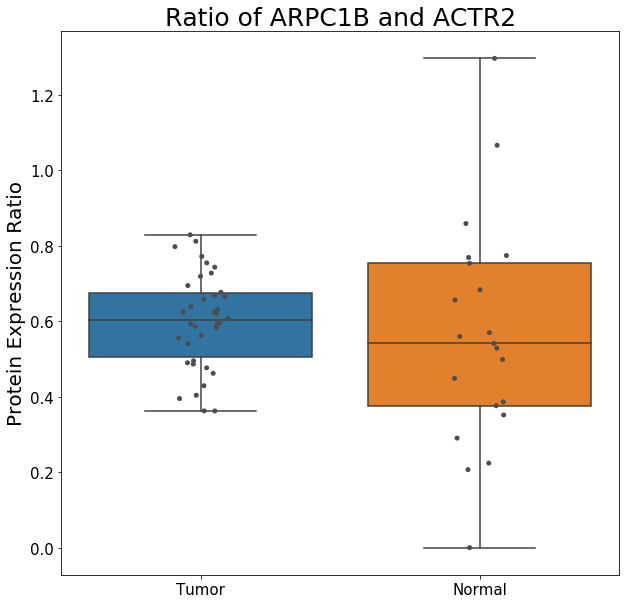

In [13]:
plot_ratios('ARPC1B', 'ACTR2')